In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.svm import SVR
from itertools import product

In [4]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
X_train, X_test, y_train, y_test = train_test_split(*make_classification(n_samples=10000,n_features=200))

In [47]:
parameter_space = {'n_estimators':[2,200],
                  'max_depth':[2,40],
                  'min_samples_split':[2,100],
                  'min_samples_leaf':[2,200],
                  }
  

In [66]:
class Minesweeper:
    def __init__(self, parameter_space):
        self.b = 3
        self.df = pd.DataFrame(columns=parameter_space.keys())
        self.df['score'] = []
        self.mms = MMS().fit(pd.DataFrame(parameter_space))
        self.dimensions = len(parameter_space)
        
    @property
    def bins(self):
        return np.linspace(0,1,self.b+1)
    
    def get_parameters(self):
        scores = self.df.pop('score')
        while True:
            all_cells = set(product(list(range(self.b)), repeat=self.dimensions))
            occupied_cells = list(set(self.df.apply(lambda x:np.digitize(x, self.bins)-1, 
                                           result_type='reduce', axis =1).apply(tuple)))
        
            relative_neighbors = (list(product((-1,0,1), repeat=self.dimensions)))
            exclude_cells = list(set([(tuple([i+j for i,j in zip(a,b)])) 
                                      for b in relative_neighbors for a in occupied_cells]))
            exclude_cells = set([x for x in exclude_cells if all(0<=i<self.b for i in x)])
        
            vacant_cells = list(all_cells-exclude_cells)
            if len(vacant_cells)==0:
                self.b+=1
                print(f'increasing b to {self.b}')
                continue
                
            chosen_cell = vacant_cells[np.random.randint(0,len(vacant_cells))]
            chosen_values = tuple([(self.bins[i]+self.bins[i+1])/2 for i in chosen_cell])
            self.df['score']=scores
            return {k:v for k,v in zip(self.mms.feature_names_in_,
                                       self.mms.inverse_transform([chosen_values])[0])}
        
    def update_values(self,values,score):
        values = pd.DataFrame(values, index=[0])
        values = pd.DataFrame(data=self.mms.transform(values), columns=values.columns)
        values['score'] = score
        
        self.df = pd.concat([self.df, values], ignore_index=True).reset_index(drop=True)
        
        
    def best_parameters(self,full=False):
        if len(self.df)<2: return self.get_parameters()
        X = (self.df if full else self.df.sample(frac=1/np.e)).copy()
        y = X.pop('score')
        svr = SVR().fit(X,y)
        observations = 100_000 if full else 1000
        predict_X = pd.DataFrame(columns=X.columns, data=np.random.uniform(size=(observations,X.shape[1])))
        predictions = svr.predict(predict_X)
        return {k:v for k,v in zip(self.mms.feature_names_in_, 
                                   self.mms.inverse_transform([predict_X.loc[predictions.argmax()]]).flatten())}
    
    @property
    def history(self):
        result = pd.DataFrame(data=self.mms.inverse_transform(self.df.iloc[:,:-1]), columns=self.mms.feature_names_in_)
        result['score'] = self.df['score']
        return result

In [67]:
ms = Minesweeper(parameter_space)

In [88]:
for i in range(40):
    if i%3==1:
        values = ms.best_parameters()
    else:
        values = ms.get_parameters()
    values = {k:int(v) for k,v in values.items()}
    print(values)
    rfc = RFC(**values, n_jobs=-1).fit(X_train,y_train)
    score = f1_score(y_test, rfc.predict(X_test))
    print(score)
    ms.update_values(values, score)
ms.df

{'n_estimators': 18, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 117}
0.8413223140495867
{'n_estimators': 150, 'max_depth': 27, 'min_samples_split': 92, 'min_samples_leaf': 169}
0.84149377593361
{'n_estimators': 117, 'max_depth': 17, 'min_samples_split': 42, 'min_samples_leaf': 84}
0.8442044038221853
{'n_estimators': 183, 'max_depth': 36, 'min_samples_split': 10, 'min_samples_leaf': 183}
0.84149377593361
{'n_estimators': 42, 'max_depth': 2, 'min_samples_split': 25, 'min_samples_leaf': 80}
0.8422370617696161
{'n_estimators': 150, 'max_depth': 24, 'min_samples_split': 91, 'min_samples_leaf': 117}
0.8407960199004973
{'n_estimators': 18, 'max_depth': 5, 'min_samples_split': 59, 'min_samples_leaf': 183}
0.8395876288659794
{'n_estimators': 111, 'max_depth': 38, 'min_samples_split': 52, 'min_samples_leaf': 164}
0.842280482729921
{'n_estimators': 183, 'max_depth': 24, 'min_samples_split': 59, 'min_samples_leaf': 150}
0.8415390980554408
{'n_estimators': 117, 'max_depth': 36, '

,n_estimators,max_depth,min_samples_split,min_samples_leaf,score
0,0.494949,0.815789,0.163265,0.494949,0.842193
1,0.494949,0.157895,0.500000,0.828283,0.841887
2,0.828283,0.500000,0.826531,0.166667,0.841494
3,0.494949,0.815789,0.826531,0.828283,0.841974
4,0.166667,0.157895,0.826531,0.166667,0.840796
...,...,...,...,...,...
87,0.782828,0.500000,0.357143,0.924242,0.843023
88,0.924242,0.631579,0.500000,0.494949,0.843284
89,0.469697,0.500000,0.214286,0.343434,0.842412
90,0.070707,0.763158,0.642857,0.641414,0.841276


In [89]:
ms.history

,n_estimators,max_depth,min_samples_split,min_samples_leaf,score
0,100.0,33.0,18.0,100.0,0.842193
1,100.0,8.0,51.0,166.0,0.841887
2,166.0,21.0,83.0,35.0,0.841494
3,100.0,33.0,83.0,166.0,0.841974
4,35.0,8.0,83.0,35.0,0.840796
...,...,...,...,...,...
87,157.0,21.0,37.0,185.0,0.843023
88,185.0,26.0,51.0,100.0,0.843284
89,95.0,21.0,23.0,70.0,0.842412
90,16.0,31.0,65.0,129.0,0.841276


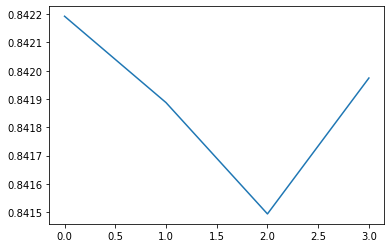

In [71]:
plt.plot(ms.df.index, ms.df['score']);

In [72]:
ms.b

3

In [59]:
ms.df.sort_values('score',ascending=False)

,n_estimators,max_depth,score
44,0.530303,0.500000,0.897927
29,0.196970,0.710526,0.897845
33,0.787879,0.947368,0.897293
27,0.949495,0.315789,0.897018
26,0.479798,0.605263,0.896689
...,...,...,...
7,0.015152,0.894737,0.876929
88,0.020202,0.447368,0.870607
98,0.020202,0.710526,0.858326
89,0.005051,0.342105,0.848265


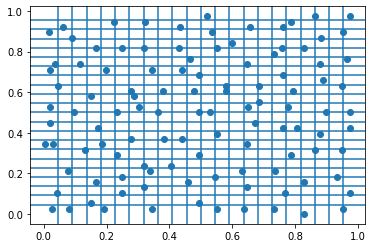

In [60]:
plt.scatter(ms.df.iloc[:,0],ms.df.iloc[:,1])
[(plt.axhline(b), plt.axvline(b)) for b in ms.bins[1:-1]];
# plt.scatter(ms.df.iloc[:,2],ms.df.iloc[:,3])

In [61]:
ms.best_parameters(full=True)

{'n_estimators': 116.78168898351154, 'max_depth': 30.62414556509424}

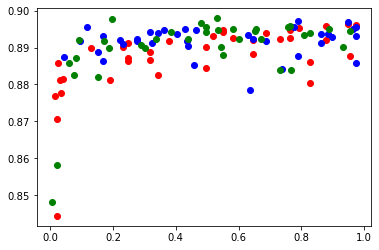

In [74]:
plt.scatter(ms.df.iloc[1::3,0], ms.df['score'][1::3], color = 'red')
plt.scatter(ms.df.iloc[0::3,0], ms.df['score'][0::3], color='blue')
plt.scatter(ms.df.iloc[2::3,0], ms.df['score'][2::3], color='green')

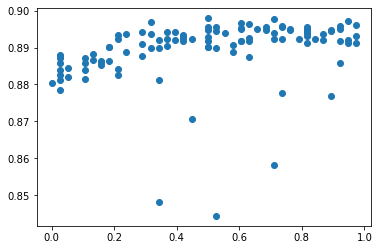

In [63]:
plt.scatter(ms.df.iloc[:,1], ms.df['score'])

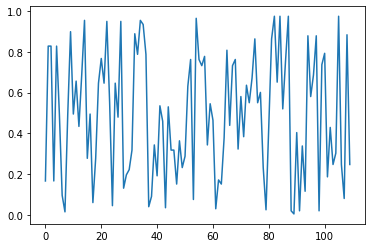

In [70]:
plt.plot(ms.df.iloc[:,0])

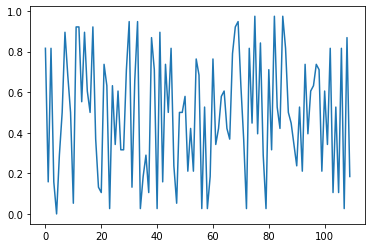

In [69]:
plt.plot(ms.df.iloc[:,1])